## 思路
* 1.先把图片变成gray（注意原始图片需要收集10张左右，用来find corners）
* 2.找到图片上的imgpoints，即corners.   cv2.findChessboardCorners(gray, (8,6), None)
* 3.Drawing detected corners on an image这个可选
* 4.Camera calibration, given object points, image points, and the shape of the grayscale image,最终得到dist:distortion coefficients 和 mtx:camera matrix 用来转换3d object points to 2d image points这两个重要参数
* 5.Undistorting a test image: dst = cv2.undistort(img, mtx, dist, None, mtx)
* 6.将dist和mtx保存为pickle，下次可以调用，并用来undistort图片.

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import pickle as pickle
%matplotlib inline

### step 1-3:
* 1.先把图片变成gray（注意原始图片需要收集10张左右，用来find corners）
* 2.找到图片上的imgpoints，即corners. cv2.findChessboardCorners(gray, (8,6), None)
* 3.Drawing detected corners on an image这个可选

In [43]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)  #这是3D世界中的点，坐标应该是3维的，(x,y,z)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #由于我们假设图片是个平面，所以z永远等于0,给x,y标号

In [44]:
objp[-5:] #[ 4.,  5.,  0.]表示 4行，5列的corner坐标

array([[ 4.,  5.,  0.],
       [ 5.,  5.,  0.],
       [ 6.,  5.,  0.],
       [ 7.,  5.,  0.],
       [ 8.,  5.,  0.]], dtype=float32)

In [45]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

In [46]:
images[:5]  #check whether the images' names have been read correctly

['./camera_cal/calibration5.jpg',
 './camera_cal/calibration15.jpg',
 './camera_cal/calibration2.jpg',
 './camera_cal/calibration8.jpg',
 './camera_cal/calibration3.jpg']

In [47]:
len(images)

20

In [48]:
mtx_all = []
dist_all = []

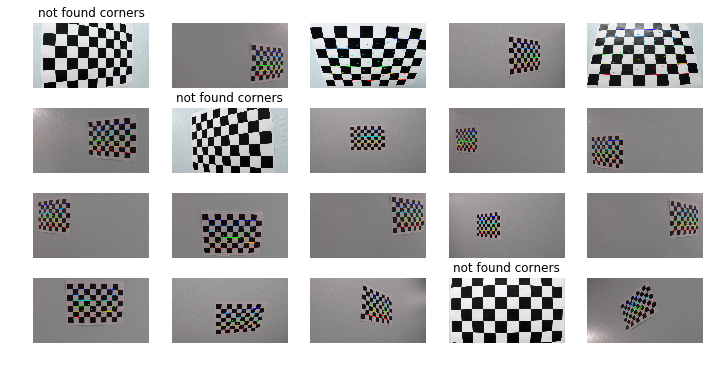

In [49]:
# Make a list of calibration images
plt.figure(figsize = (12,6))
index=0
ret_num=0
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #turn the origin image to gray

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
    plt.subplot(4,5,index+1)
    
    index+=1
    # If found, add object points, image points
    if ret == True:
        ret_num+=1
        objpoints.append(objp)              #这是事先要准备好，是用来表示3D的点坐标
        imgpoints.append(corners)           #这是找到的2D图片上的点

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        
    else:
        plt.imshow(img)
        plt.title('not found corners')
    plt.axis('off')

In [50]:
ret_num #only 17 images in the total 20 images can be found corners.

17

#### zoom in simple image to check the finding corner result

./camera_cal/calibration3.jpg


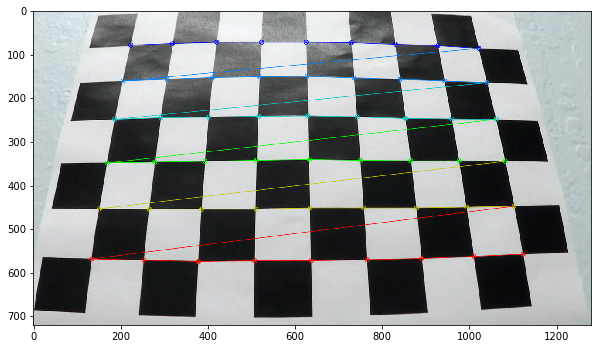

In [52]:
fname_test='./camera_cal/calibration3.jpg'
print(fname_test)
img_test = cv2.imread(fname_test)
gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (10,6))

# Find the chessboard corners
ret_test, corners_test = cv2.findChessboardCorners(gray_test, (9,6), None)
        
if ret_test == True:

    cv2.drawChessboardCorners(img_test, (9,6), corners_test, ret_test)
    plt.imshow(img_test)

### step 4-6:
* 4.Camera calibration, given object points, image points, and the shape of the grayscale image,最终得到dist:distortion coefficients 和 mtx:camera matrix 用来转换3d object points to 2d image points这两个重要参数
* 5.Undistorting a test image: dst = cv2.undistort(img, mtx, dist, None, mtx)
* 6.将dist和mtx保存为pickle，下次可以调用，并用来undistort图片.

In [53]:
len(imgpoints[0])  #看下找到的2D图上的点的个数是不是6*9=54

54

In [54]:
img.shape

(720, 1280, 3)

In [61]:
# Test undistortion on an image
img_dist = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img_dist.shape[1], img_dist.shape[0])

In [62]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                   img_size,None,None)

In [63]:
#undistort the origin image to destination image
dst = cv2.undistort(img_undist, mtx, dist, None, mtx)

In [64]:
cv2.imwrite('./test_images/camera_cal_undist.jpg',dst)

True

In [69]:
#find undist image's coners
gray_undist = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret_undist, corners_undist = cv2.findChessboardCorners(gray_undist, (9,6), None)    

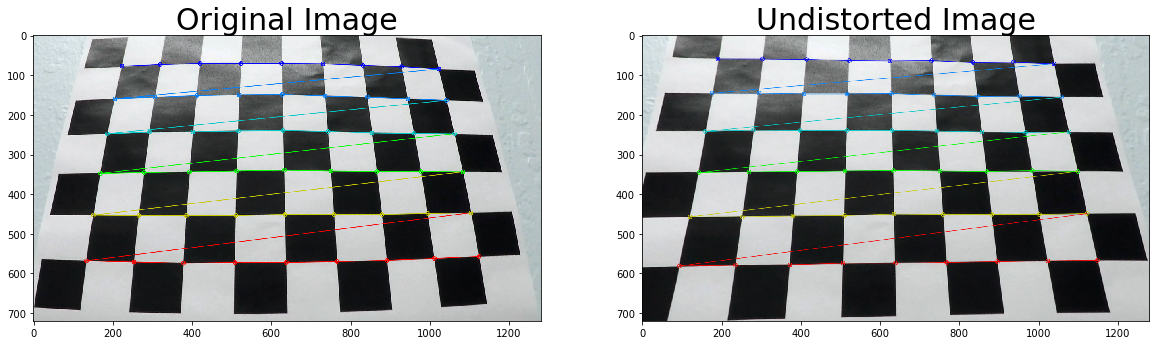

In [70]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.drawChessboardCorners(img_dist, (9,6), corners_test, ret_test)
ax1.imshow(img_dist)
ax1.set_title('Original Image', fontsize=30)
cv2.drawChessboardCorners(dst, (9,6), corners_undist, ret_undist)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [71]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "mtx_dist_pickle.p", "wb" ) )